# Network-Coarsened Fiduccia-Mattheyses (FM) Partitioning Walkthrough

This notebook provides a comprehensive walkthrough of the **Network-Coarsened FM** algorithm, which is an advanced multilevel partitioning approach that combines:

1. **Network Coarsening**: Recursively coarsening the quantum network topology
2. **Network Cutting**: Dividing the coarsened network into sub-networks at each level
3. **Subgraph Partitioning**: Creating subgraphs with dummy nodes for each sub-network
4. **Multilevel FM**: Applying the Fiduccia-Mattheyses algorithm at multiple coarsening levels
5. **Solution Stitching**: Combining the partitioned subgraphs back into a complete solution

The algorithm is particularly effective for heterogeneous quantum networks where different QPUs have varying capacities and connectivity patterns.

## Problem Setup

We'll demonstrate the algorithm using:
- **Circuit**: 16-qubit quantum circuit (Quantum Volume)
- **Network**: 4-node linear network topology
- **Coarsening Factor**: l=2 (each coarsening step reduces network by factor of 2)

Let's begin by setting up our problem instance and visualizing each stage of the algorithm.

In [1]:
# Load TikZ extension for drawing
%load_ext jupyter_tikz

# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from copy import deepcopy
from qiskit.circuit.library import QuantumVolume

# MLQCP_FM imports
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph, SubGraphManager
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

from disqco.parti.FM.FM_hetero import run_FM_sparse
from disqco.drawing.tikz_drawing import draw_graph_tikz, draw_subgraph_tikz

print("✅ All imports successful!")
print("✅ TikZ extension loaded!")
print("This notebook will walk through the Network-Coarsened FM algorithm step by step.")

✅ All imports successful!
✅ TikZ extension loaded!
This notebook will walk through the Network-Coarsened FM algorithm step by step.


In [2]:
# Helper functions for sparse FM algorithm

def check_assignment_validity(assignment, qpu_sizes, subgraph):
    """
    Check if an assignment is valid (all qubits assigned to valid partitions within capacity).
    """
    # Count assignments to each partition
    partition_counts = [{qpu: 0 for qpu in qpu_sizes.keys()} for t in range(assignment.shape[0])]
    
    # Handle both 2D arrays and lists of lists
    for node in subgraph.nodes:
        if isinstance(node, tuple) and len(node) == 2:
            q, t = node
            node_partition = assignment[t][q]
            partition_counts[t][node_partition] += 1

    # Check capacity constraints
    print(f"Partition counts for subgraph: {partition_counts}")
    for t in range(assignment.shape[0]):
        for partition in partition_counts[t]:
            if partition_counts[t][partition] > qpu_sizes[partition]:
                print(f"Layer {t}, partition {partition} exceeds capacity: {partition_counts[t][partition]} > {qpu_sizes[partition]}")
                print(f"Assignment for layer {t}: {assignment[t]}   ")
                for i, element in enumerate(assignment[t]):
                    element_tm1 = assignment[t-1][i] if t > 0 else None
                    if element_tm1 != element:
                        print(f"Element {i} changed from {element_tm1} to {element} in layer {t}")
                return False
    
    return True

def set_initial_partitions_sparse(assignment, active_nodes, qpu_sizes, subgraph):
    """
    Create a sparse assignment from a full assignment for a specific set of active nodes.
    
    Args:
        assignment: Full assignment (2D array or list of lists)
        active_nodes: Set of active QPU nodes for this subgraph
        qpu_sizes: Dict mapping QPU nodes to their sizes
        subgraph: The subgraph being processed
        
    Returns:
        numpy array: Sparse assignment with -1 for inactive partitions
    """
    import numpy as np
    
    # Convert to numpy array if needed
    if not hasattr(assignment, 'shape'):
        assignment = np.array(assignment)
    
    # Create mapping from original QPU indices to sparse indices
    active_list = sorted(list(active_nodes))
    qpu_to_sparse = {qpu: i for i, qpu in enumerate(active_list)}
    
    # Initialize sparse assignment with -1 (unassigned)
    sparse_assignment = np.full_like(assignment, -1, dtype=int)
    
    # Copy assignments for active nodes
    for t in range(assignment.shape[0]):
        for q in range(assignment.shape[1]):
            original_qpu = assignment[t, q]
            if original_qpu in qpu_to_sparse:
                sparse_assignment[t, q] = qpu_to_sparse[original_qpu]
    
    return sparse_assignment

def check_assignment_validity_internal(assignment, qpu_sizes, active_nodes):
    """Internal function to check assignment validity"""
    for t, layer in enumerate(assignment.tolist()):
        for qpu_id in qpu_sizes:
            if qpu_id not in active_nodes:
                continue
            num_js = layer.count(qpu_id)
            if num_js > qpu_sizes[qpu_id]:
                
                print(f"Layer {t}, partition {qpu_id} exceeds capacity: {num_js} > {qpu_sizes[qpu_id]}")
                return False
    return True

## Step 1: Problem Instance Creation

First, we create our quantum circuit and network topology. We'll use a 16-qubit Quantum Volume circuit and a 4-node linear network where each QPU can handle 4 qubits.

✅ Created 32-qubit Quantum Volume circuit
   Circuit depth: 32
   Gate counts: OrderedDict({'u': 251, 'cp': 245})
✅ Created 16-node linear quantum network
   QPU sizes: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
   Connectivity: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15]]
   Total capacity: 48 qubits
✅ Created hypergraph representation
   Number of nodes: 1024
   Number of hyperedges: 1098
   Circuit depth in hypergraph: 32


/var/folders/s5/7cd6cqh90fd7qlk1kl1bnr0w0000gp/T/ipykernel_44655/2512221238.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


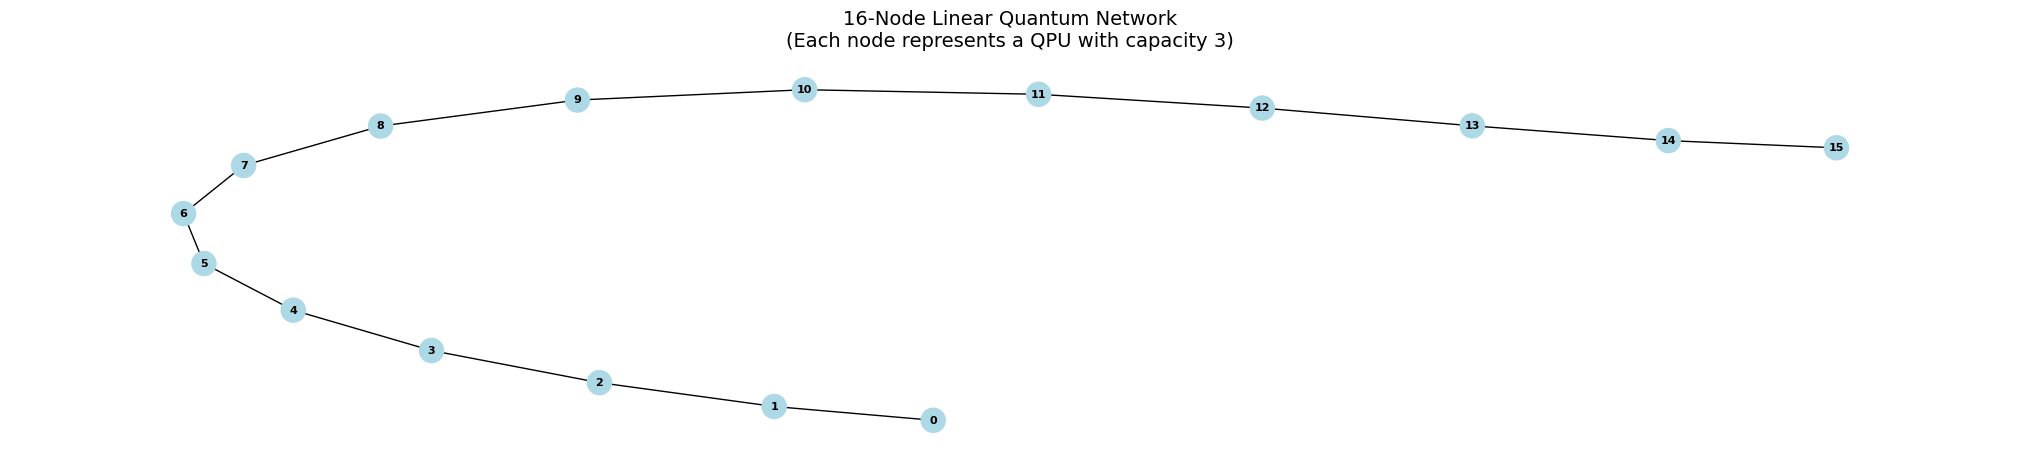

In [3]:
# Problem parameters
num_qubits = 32
num_qpus = 16  # 4-node linear network
qpu_capacity = int(np.ceil(num_qubits / num_qpus)) + 1 
coarsening_factor = 2  # l=2

# Create the quantum circuit (16-qubit Quantum Volume)
from qiskit import transpile
from disqco.circuits.cp_fraction import cp_fraction

# circuit = QuantumVolume(num_qubits, depth=10, seed=42)
circuit = cp_fraction(num_qubits, depth=num_qubits, fraction=0.5, seed=42)
# Transpile to the right gate set
circuit = transpile(circuit, basis_gates=['u', 'cp'])

print(f"✅ Created {num_qubits}-qubit Quantum Volume circuit")
print(f"   Circuit depth: {circuit.depth()}")
gate_counts = circuit.count_ops()
print(f"   Gate counts: {gate_counts}")

# Create the quantum network (4-node linear topology)
qpu_sizes = [qpu_capacity] * num_qpus  # [4, 4, 4, 4]
connectivity = linear_coupling(num_qpus)  # [(0,1), (1,2), (2,3)]
# connectivity = grid_coupling(num_qpus)  


initial_network = QuantumNetwork(qpu_sizes, connectivity)

network = deepcopy(initial_network)  # Use a copy to avoid modifying the original

print(f"✅ Created {num_qpus}-node linear quantum network")
print(f"   QPU sizes: {qpu_sizes}")
print(f"   Connectivity: {connectivity}")
print(f"   Total capacity: {sum(qpu_sizes)} qubits")

# Create the hypergraph representation
hypergraph = QuantumCircuitHyperGraph(circuit)
print(f"✅ Created hypergraph representation")
print(f"   Number of nodes: {len(hypergraph.nodes)}")
print(f"   Number of hyperedges: {len(hypergraph.hyperedges)}")
print(f"   Circuit depth in hypergraph: {hypergraph.depth}")

# Visualize the network topology
# Scale figure and node sizes based on network size
fig_width = max(8, min(20, num_qpus * 1.5))
plt.figure(figsize=(fig_width, 4))

# Position nodes with proper spacing
spacing = max(1.0, 8.0 / num_qpus)  # Adaptive spacing
# pos = {i: (i * spacing, 0) for i in range(num_qpus)}

# Scale node sizes and font based on network size
base_node_size = max(300, 2000 / num_qpus)  # Smaller nodes for larger networks
node_sizes = [base_node_size * size / max(qpu_sizes) for size in qpu_sizes]
font_size = max(8, min(16, 120 / num_qpus))  # Scale font with network size

nx.draw(network.qpu_graph, with_labels=True, 
        node_size=node_sizes, node_color='lightblue', 
        font_size=font_size, font_weight='bold')

plt.title(f"{num_qpus}-Node Linear Quantum Network\n(Each node represents a QPU with capacity {qpu_capacity})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

### Initial Hypergraph Visualization

Let's visualize the initial hypergraph representation of our quantum circuit. This shows the temporal structure where each node represents a qubit at a specific time step, and hyperedges represent quantum gates.

In [4]:
# Create a simple initial assignment for visualization (round-robin)
initial_assignment = []
for t in range(hypergraph.depth):
    layer_assignment = []
    for q in range(num_qubits):
        layer_assignment.append(q % num_qpus)  # Round-robin assignment
    initial_assignment.append(layer_assignment)

print("Initial assignment pattern (round-robin):")
for t in range(min(3, len(initial_assignment))):  # Show first 3 layers
    print(f"  Time {t}: {initial_assignment[t]}")
if len(initial_assignment) > 3:
    print("  ...")

# Visualize the initial hypergraph with assignment

# fig = draw_graph_tikz(hypergraph, initial_assignment, qpu_sizes, 
#                    fill_background=True, show_labels=True)

# display(fig)

def refine_assignment_sparse(level, num_levels, assignment, mapping_list, subgraph, next_graph, qpu_sizes):
    new_assignment = assignment
    # First check assignment validity
    # if not check_assignment_validity(new_assignment, qpu_sizes, subgraph):
    #     print(f"Invalid assignment at level {level}. Cannot refine.")
    #     raise ValueError("Invalid assignment")
    unassigned_nodes = set()
    if level < num_levels - 1:
        for super_node_t in mapping_list[level]:
            print(f"Refining assignment for super node {super_node_t} at level {level}")
            print(f"  Contained time steps: {mapping_list[level][super_node_t]}")
            for t in mapping_list[level][super_node_t]:
                for q in range(len(assignment[0])):
                    # super_node_t = mapping_list[level][super_node_t]  # Get the first time step in the super node
                    
                    if (q,t) in next_graph.nodes and (q, super_node_t) in next_graph.nodes:
                        print(f"  Assigning qubit {(q,t)} to super node {(q,super_node_t)}")
                        # if t < len(new_assignment) and super_node_t < len(assignment):
                        new_assignment[t][q] = assignment[super_node_t][q]
                    elif (q, t) in next_graph.nodes and (q, super_node_t) not in next_graph.nodes:
                        print(f"New qubit has entered, assign where space is available after others")
                        unassigned_nodes.add((q, t))

    partition_counts = [{qpu: 0 for qpu in qpu_sizes.keys()} for t in range(assignment.shape[0])]
    
    # Handle both 2D arrays and lists of lists
    for node in set(subgraph.nodes) - unassigned_nodes:
        if isinstance(node, tuple) and len(node) == 2:
            q, t = node
            node_partition = assignment[t][q]
            partition_counts[t][node_partition] += 1
    
    for node in unassigned_nodes:
        q, t = node
        # Find the first partition with available space
        for partition, size in qpu_sizes.items():
            if partition_counts[t][partition] < size:
                new_assignment[t][q] = partition
                partition_counts[t][partition] += 1
                print(f"Assigned unassigned node {(q,t)} to partition {partition}")
                break
        else:
            print(f"No available partition for unassigned node {(q,t)}")

    return new_assignment

Initial assignment pattern (round-robin):
  Time 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Time 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Time 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  ...


## Step 2: Network Coarsening

The first stage of the algorithm is to coarsen the quantum network. This creates a hierarchy of networks, where each level has fewer nodes but represents the same connectivity structure at a coarser granularity.

In [5]:
# Initialize the network coarsener
net_coarsener = NetworkCoarsener(network)
print(f"🔧 Initialized NetworkCoarsener")
print(f"   Initial network: {net_coarsener.initial_network.num_qpus} QPUs")

# Perform recursive network coarsening
print(f"\\n🔄 Starting recursive network coarsening with l={coarsening_factor}")
start_time = time.time()
net_coarsener.coarsen_network_recursive(l=coarsening_factor)
coarsening_time = time.time() - start_time

print(f"✅ Network coarsening complete in {coarsening_time:.4f} seconds")
print(f"   Number of coarsening levels: {len(net_coarsener.network_coarse_list)}")

# Examine the coarsening hierarchy
print("\\n📊 Network Coarsening Hierarchy:")
for i, network_level in enumerate(net_coarsener.network_coarse_list):
    num_nodes = len(network_level.qpu_graph.nodes)
    qpu_sizes_level = [network_level.qpu_graph.nodes[node]['size'] for node in network_level.qpu_graph.nodes]
    print(f"   Level {i}: {num_nodes} nodes, sizes {qpu_sizes_level}")

# Set up the final coarsened network
final_network = net_coarsener.network_coarse_list[-1]
final_network.active_nodes = set(final_network.qpu_graph.nodes)

🔧 Initialized NetworkCoarsener
   Initial network: 16 QPUs
\n🔄 Starting recursive network coarsening with l=2
✅ Network coarsening complete in 0.0010 seconds
   Number of coarsening levels: 4
\n📊 Network Coarsening Hierarchy:
   Level 0: 16 nodes, sizes [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
   Level 1: 8 nodes, sizes [5, 5, 5, 5, 5, 5, 5, 5]
   Level 2: 4 nodes, sizes [9, 9, 9, 9]
   Level 3: 2 nodes, sizes [17, 17]


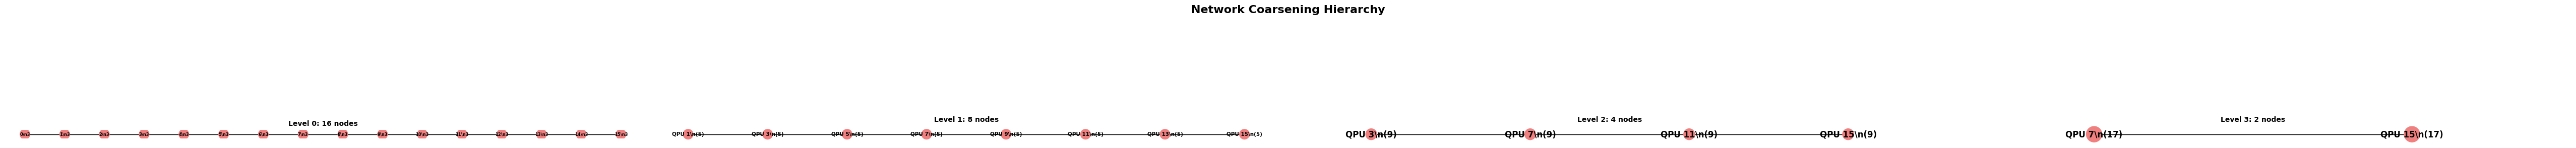

🎨 Network coarsening visualization complete!
   Each level shows the network after coarsening operations
   Node sizes represent QPU capacities (number of qubits each can handle)


In [6]:
# Visualize the network coarsening hierarchy
# Scale figure size based on number of levels and max nodes
max_nodes_in_level = max(len(level.qpu_graph.nodes) for level in net_coarsener.network_coarse_list)
fig_width = max(4, len(net_coarsener.network_coarse_list) * max(3, max_nodes_in_level * 0.8))
fig, axes = plt.subplots(1, len(net_coarsener.network_coarse_list), 
                        figsize=(fig_width, 5))

if len(net_coarsener.network_coarse_list) == 1:
    axes = [axes]

for i, network_level in enumerate(net_coarsener.network_coarse_list):
    ax = axes[i]
    
    # Create layout for this network level with adaptive spacing
    G = network_level.qpu_graph
    num_nodes = len(G.nodes)
    
    if num_nodes == 1:
        pos = {list(G.nodes)[0]: (0, 0)}
        spacing = 1
    else:
        spacing = max(0.5, 4.0 / num_nodes)  # Adaptive spacing
        pos = {node: (idx * spacing, 0) for idx, node in enumerate(G.nodes)}
    
    # Scale node sizes and font based on number of nodes
    base_size = max(200, 1000 / num_nodes)
    node_sizes = [base_size * G.nodes[node]['size'] / max(G.nodes[n]['size'] for n in G.nodes) for node in G.nodes]
    font_size = max(6, min(12, 60 / num_nodes))
    
    # Create compact labels
    if num_nodes <= 8:
        node_labels = {node: f"QPU {node}\\n({G.nodes[node]['size']})" for node in G.nodes}
    else:
        node_labels = {node: f"{node}\\n{G.nodes[node]['size']}" for node in G.nodes}
    
    nx.draw(G, pos=pos, ax=ax, with_labels=True, labels=node_labels,
            node_size=node_sizes, node_color='lightcoral',
            font_size=font_size, font_weight='bold')
    
    ax.set_title(f"Level {i}: {len(G.nodes)} nodes", fontsize=max(10, 14 - len(net_coarsener.network_coarse_list)), fontweight='bold')
    ax.set_aspect('equal')
    
    # Adjust axis limits based on spacing
    if num_nodes > 1:
        ax.set_xlim(-spacing * 0.5, (num_nodes - 1) * spacing + spacing * 0.5)

plt.suptitle("Network Coarsening Hierarchy", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("🎨 Network coarsening visualization complete!")
print("   Each level shows the network after coarsening operations")
print("   Node sizes represent QPU capacities (number of qubits each can handle)")

## Step 3: Network Cutting and Sub-Network Generation

After coarsening the network, we systematically "cut" or divide it into sub-networks at each level. This creates a tree-like structure where each node in a coarser network corresponds to multiple sub-networks in the finer level.

In [7]:
# Initialize the network level list with the most coarsened network
network_level_list = []
network_level_list.append({None: final_network})  # Dict: {source_node: network}
networks = network_level_list[0]

print(f"🔧 Starting network cutting process")
print(f"   Initial level has {len(networks)} sub-networks")

# Perform network cutting for each coarsening level
start_time = time.time()
for i in range(len(net_coarsener.network_coarse_list) - 1):
    print(f"\n📂 Cutting networks at level {i}")
    prev_networks = network_level_list[i]
    print(f"   Input: {len(prev_networks)} networks")
    
    new_networks = net_coarsener.cut_network(prev_networks, level=i)
    network_level_list.append(new_networks)
    
    print(f"   Output: {len(new_networks)} networks")
    
    # Show details of the new networks
    for source_node, network in new_networks.items():
        active_nodes = network.active_nodes
        node_sizes = [network.qpu_graph.nodes[node]['size'] for node in active_nodes]
        print(f"     Sub-network {source_node}: {len(active_nodes)} active nodes, sizes {node_sizes}")

cutting_time = time.time() - start_time
print(f"\n✅ Network cutting complete in {cutting_time:.4f} seconds")
print(f"   Total levels created: {len(network_level_list)}")

# Summary of the network hierarchy
print("\n📊 Complete Network Hierarchy:")
for level, networks in enumerate(network_level_list):
    print(f"   Level {level}: {len(networks)} sub-networks")
    for source_node, net in networks.items():
        active_nodes = net.active_nodes
        sizes = [net.qpu_graph.nodes[node]['size'] for node in active_nodes]
        print(f"     Sub-net {source_node}: {len(active_nodes)} nodes, sizes {sizes}")

🔧 Starting network cutting process
   Initial level has 1 sub-networks

📂 Cutting networks at level 0
   Input: 1 networks
   Output: 2 networks
     Sub-network 15: 2 active nodes, sizes [9, 9]
     Sub-network 7: 2 active nodes, sizes [9, 9]

📂 Cutting networks at level 1
   Input: 2 networks
   Output: 4 networks
     Sub-network 11: 2 active nodes, sizes [5, 5]
     Sub-network 15: 2 active nodes, sizes [5, 5]
     Sub-network 3: 2 active nodes, sizes [5, 5]
     Sub-network 7: 2 active nodes, sizes [5, 5]

📂 Cutting networks at level 2
   Input: 4 networks
   Output: 8 networks
     Sub-network 9: 2 active nodes, sizes [3, 3]
     Sub-network 11: 2 active nodes, sizes [3, 3]
     Sub-network 13: 2 active nodes, sizes [3, 3]
     Sub-network 15: 2 active nodes, sizes [3, 3]
     Sub-network 1: 2 active nodes, sizes [3, 3]
     Sub-network 3: 2 active nodes, sizes [3, 3]
     Sub-network 5: 2 active nodes, sizes [3, 3]
     Sub-network 7: 2 active nodes, sizes [3, 3]

✅ Network cutt

🎨 Visualizing network cutting hierarchy...


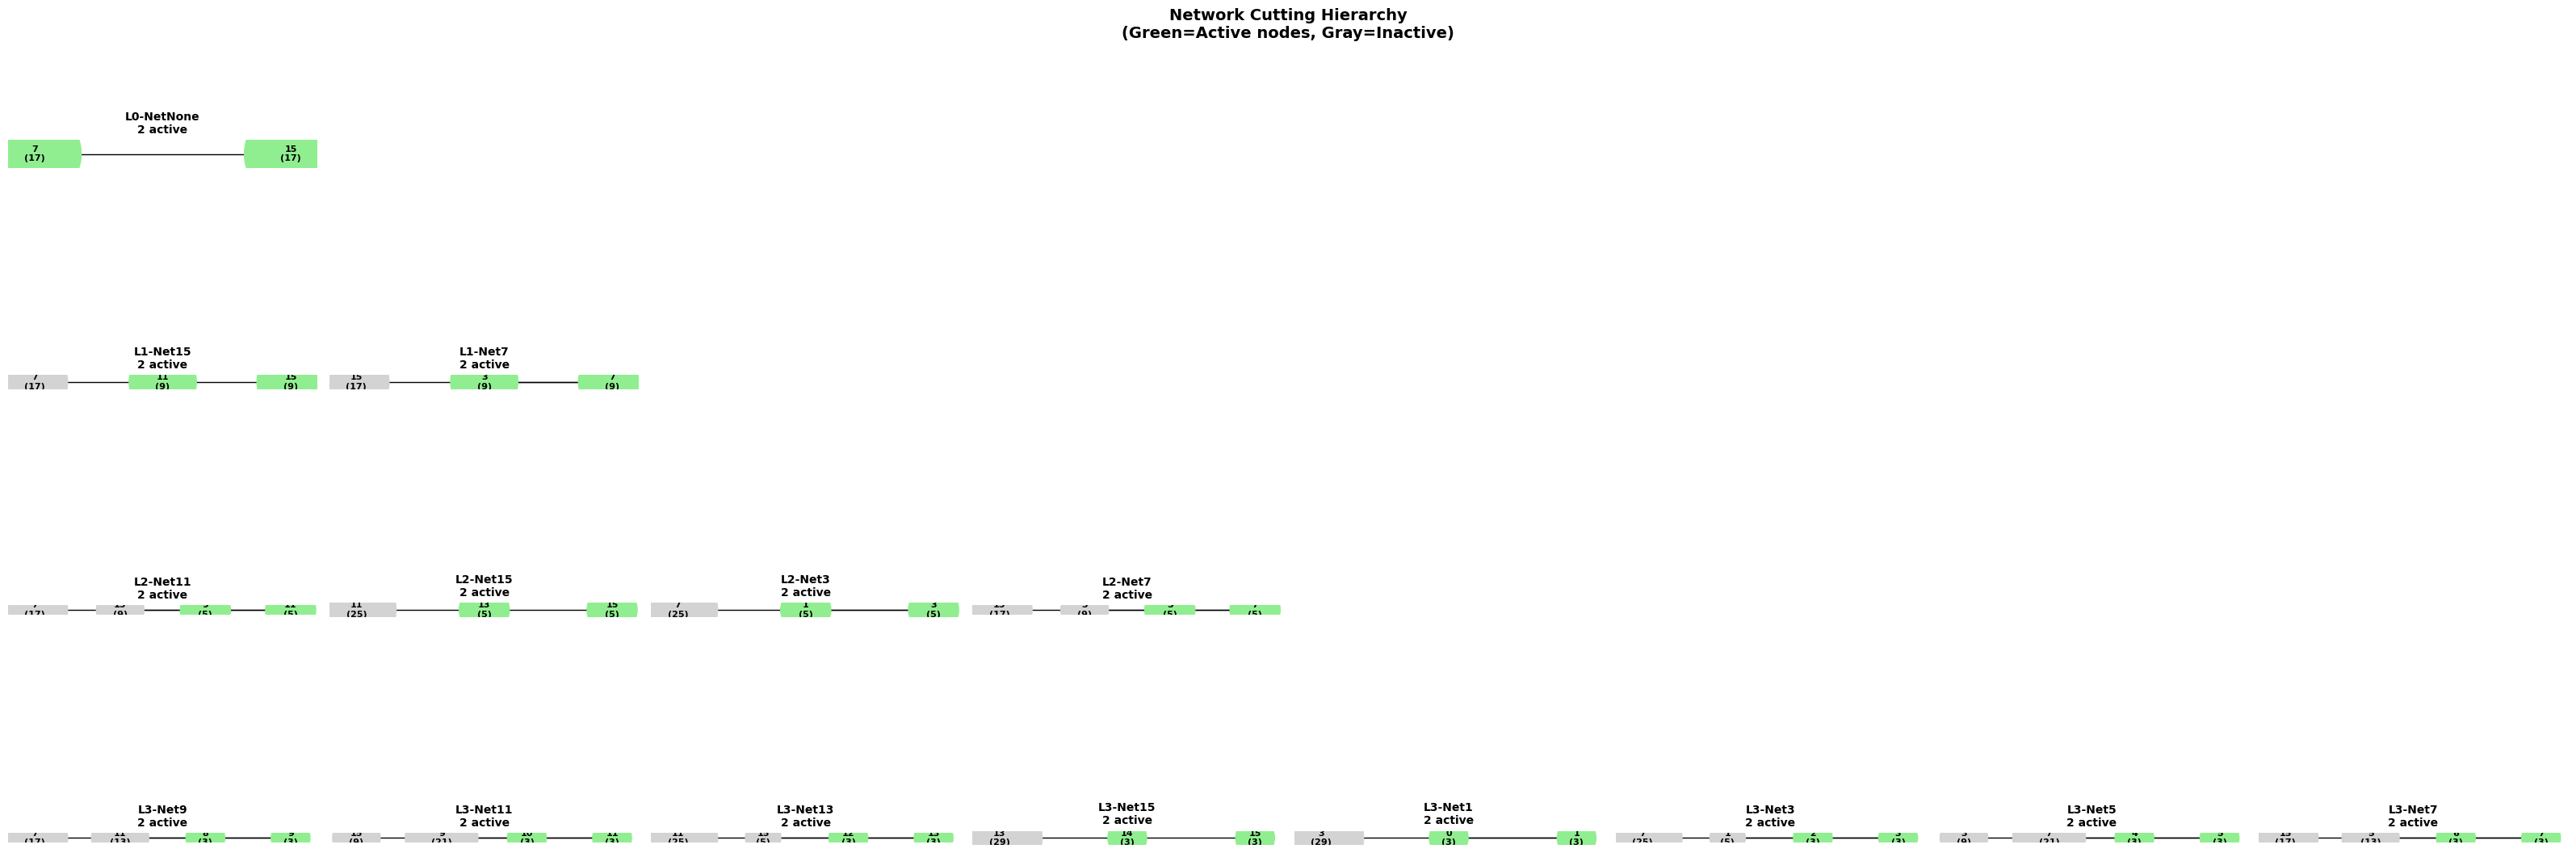

✅ Network cutting visualization complete!
   Each row shows a different coarsening level
   Each column shows a different sub-network at that level
   Green nodes are active in the sub-network, gray nodes are inactive


In [8]:
# Visualize the network cutting hierarchy
print("🎨 Visualizing network cutting hierarchy...")

max_networks = max(len(networks) for networks in network_level_list)
fig, axes = plt.subplots(len(network_level_list), max_networks, 
                        figsize=(4 * max_networks, 3 * len(network_level_list)))

# Handle case where there's only one level or one network
if len(network_level_list) == 1:
    axes = [axes]
if max_networks == 1:
    axes = [[ax] for ax in axes]

for level_idx, networks in enumerate(network_level_list):
    for net_idx, (source_node, network) in enumerate(networks.items()):
        if net_idx < max_networks:  # Ensure we don't exceed subplot grid
            ax = axes[level_idx][net_idx]
            
            G = network.qpu_graph
            active_nodes = network.active_nodes
            
            # Create layout
            if len(G.nodes) == 1:
                pos = {list(G.nodes)[0]: (0, 0)}
            else:
                pos = {node: (idx, 0) for idx, node in enumerate(G.nodes)}
            
            # Color nodes based on whether they're active
            node_colors = []
            node_sizes = []
            for node in G.nodes:
                if node in active_nodes:
                    node_colors.append('lightgreen')
                    node_sizes.append(400 * G.nodes[node]['size'])
                else:
                    node_colors.append('lightgray')
                    node_sizes.append(200 * G.nodes[node]['size'])
            
            # Create labels showing QPU IDs and sizes
            node_labels = {node: f"{node}\n({G.nodes[node]['size']})" for node in G.nodes}
            
            nx.draw(G, pos=pos, ax=ax, with_labels=True, labels=node_labels,
                    node_size=node_sizes, node_color=node_colors,
                    font_size=8, font_weight='bold')
            
            ax.set_title(f"L{level_idx}-Net{source_node}\n{len(active_nodes)} active", 
                        fontsize=10, fontweight='bold')
            ax.set_aspect('equal')
    
    # Hide unused subplots
    for net_idx in range(len(networks), max_networks):
        if net_idx < max_networks:
            axes[level_idx][net_idx].set_visible(False)

plt.suptitle("Network Cutting Hierarchy\n(Green=Active nodes, Gray=Inactive)", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Network cutting visualization complete!")
print("   Each row shows a different coarsening level")
print("   Each column shows a different sub-network at that level")
print("   Green nodes are active in the sub-network, gray nodes are inactive")

## Step 3.5: Initial Partitioning on Coarsest Network

Before creating subgraphs, we need to perform an initial partitioning of the circuit on the coarsest network level. This provides the baseline assignment that will be used to determine which nodes become "dummy nodes" in each subgraph.

In [9]:
from disqco.parti.FM.FM_methods import set_initial_partition_assignment
# Perform initial partitioning on the coarsest network
print("🎯 Performing initial partitioning on coarsest network...")

# Use the coarsest network (first level in our hierarchy)
coarsest_networks = network_level_list[0]
coarsest_network = list(coarsest_networks.values())[0]
coarsest_active_nodes = coarsest_network.active_nodes

print(f"   Coarsest network: {len(coarsest_active_nodes)} active nodes")
print(f"   Active nodes: {list(coarsest_active_nodes)}")

# Set up initial assignment using simple strategy
num_coarsest_qpus = len(coarsest_active_nodes)


# Run FM optimization on the coarsest level to get a good starting point
print("\\n🔧 Running FM optimization on coarsest network...")

start_time = time.time()

# Create node mapping for coarsest network
coarsest_node_map = {list(coarsest_active_nodes)[i] : i for i in range(len(coarsest_active_nodes))}
# Create sparse assignment for coarsest network
coarsest_qpu_sizes = {qpu: coarsest_network.qpu_graph.nodes[qpu]['size'] for qpu in coarsest_active_nodes}

print(f"   Coarsest node map : {coarsest_node_map}")

initial_assignment_coarse = set_initial_partition_assignment(
    graph=hypergraph,
    network=coarsest_network,
    node_map=coarsest_node_map,
)


print(f"   Sparse assignment: {initial_assignment_coarse}")


# # Run sparse FM on the coarsest network
# final_cost, final_assignment, cost_list = run_FM_sparse(
#     hypergraph,
#     initial_assignment_coarse,
#     coarsest_qpu_sizes,
#     len(coarsest_active_nodes),
#     coarsest_active_nodes,
#     limit=num_qubits*hypergraph.depth*0.125,
#     passes=100,  # Quick optimization
#     stochastic=True,
#     log=True,
#     network=coarsest_network,
#     node_map=coarsest_node_map,
#     dummy_nodes=set()
# )
from disqco.parti.FM.fiduccia import *

FM_partitioner = FiducciaMattheyses(circuit=circuit,
                                    network=coarsest_network,
                                    initial_assignment=initial_assignment_coarse,
                                    sparse=True )

coarsener = HypergraphCoarsener()
coarsening_method = coarsener.coarsen_recursive_subgraph_batch
results = FM_partitioner.multilevel_partition(coarsener=coarsening_method, sparse=True)
# results = FM_partitioner.partition(sparse=True)

optimized_assignment_coarse = results['best_assignment']
best_cost = results['best_cost']

optimization_time = time.time() - start_time

print(f'Best assignment on coarsest network: {optimized_assignment_coarse}')
print(f'Best cost on coarsest network: {best_cost}')

🎯 Performing initial partitioning on coarsest network...
   Coarsest network: 2 active nodes
   Active nodes: [15, 7]
\n🔧 Running FM optimization on coarsest network...
   Coarsest node map : {15: 0, 7: 1}
   Sparse assignment: [[15 15 15 ...  7  7  7]
 [15 15 15 ...  7  7  7]
 [15 15 15 ...  7  7  7]
 ...
 [15 15 15 ...  7  7  7]
 [15 15 15 ...  7  7  7]
 [15 15 15 ...  7  7  7]]
Best assignment on coarsest network: [[ 7 15 15 ... 15  7 15]
 [ 7 15 15 ... 15  7 15]
 [ 7 15  7 ... 15  7 15]
 ...
 [15  7 15 ... 15  7 15]
 [15  7 15 ... 15  7 15]
 [15  7 15 ... 15  7 15]]
Best cost on coarsest network: 48


\n🎨 Drawing optimized assignment with TikZ...


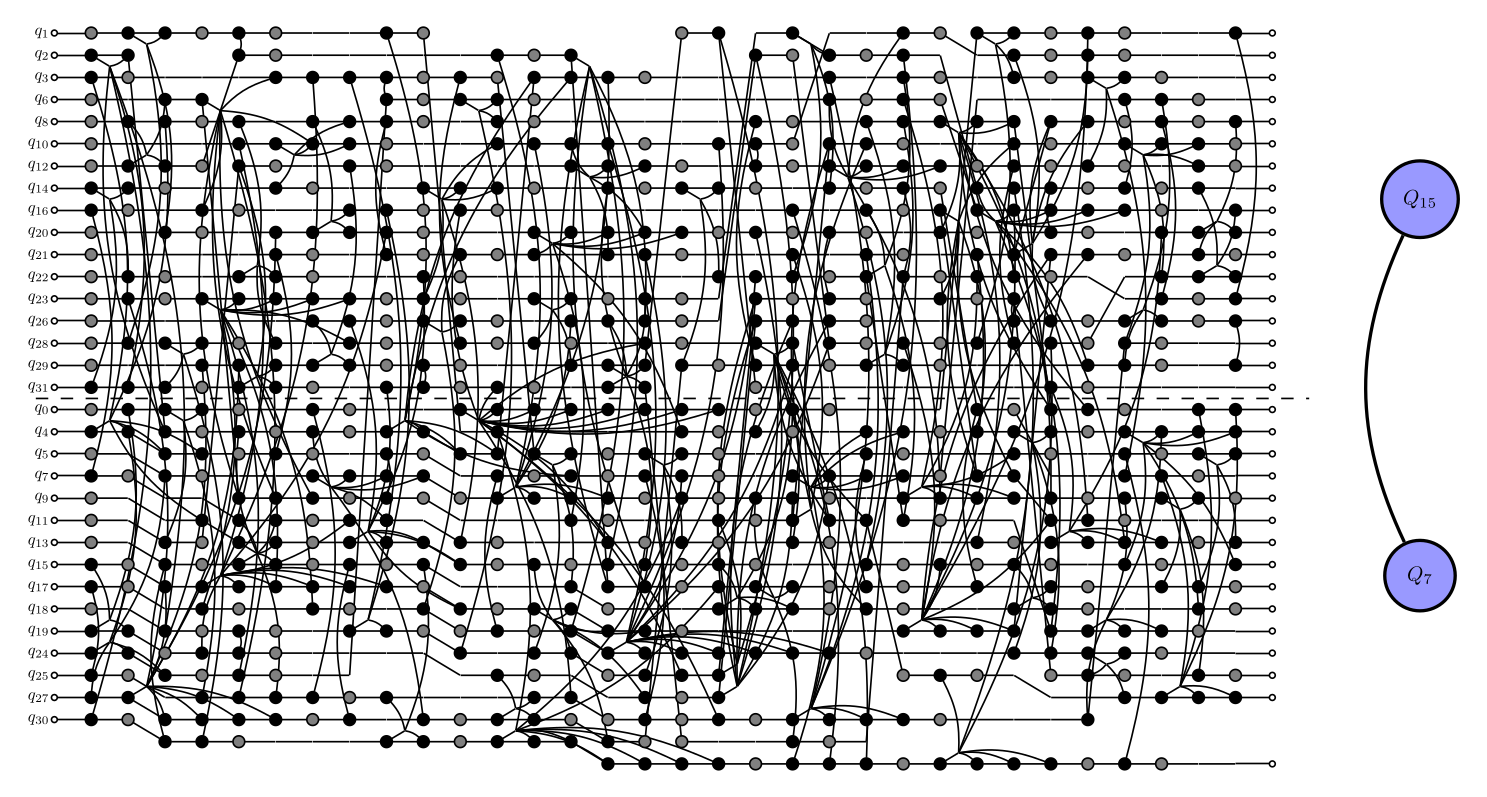

In [10]:
# Visualize the optimized assignment using TikZ
print("\\n🎨 Drawing optimized assignment with TikZ...")

fig = draw_subgraph_tikz(hypergraph, optimized_assignment_coarse, coarsest_qpu_sizes, 
                         node_map=coarsest_node_map,
                         network=coarsest_network,
                         fill_background=True, show_labels=False, tikz_raw=False)
display(fig)


## Step 4: Subgraph Creation with Dummy Nodes

Now we create subgraphs from the original hypergraph for each sub-network. The key innovation is that nodes belonging to other partitions are replaced with "dummy nodes" that represent the external partitions. This allows each subgraph to be optimized independently while maintaining awareness of external dependencies.

In [11]:
# Initialize subgraph management
sub_graph_manager = SubGraphManager(hypergraph)
print(f"🔧 Initialized SubGraphManager")


print(networks)

# Use the SubGraphManager to create actual subgraphs with dummy nodes
subgraphs = sub_graph_manager.build_partition_subgraphs(
    graph=hypergraph,
    assignment=optimized_assignment_coarse,
    current_network=coarsest_network,
    new_networks=network_level_list[1],
    old_dummy_nodes=set()
)

print(f"   ✅ Successfully created {len(subgraphs)} subgraphs with dummy nodes!")


🔧 Initialized SubGraphManager
{9: <disqco.graphs.quantum_network.QuantumNetwork object at 0x125074670>, 11: <disqco.graphs.quantum_network.QuantumNetwork object at 0x1250749f0>, 13: <disqco.graphs.quantum_network.QuantumNetwork object at 0x12507f380>, 15: <disqco.graphs.quantum_network.QuantumNetwork object at 0x12502b7d0>, 1: <disqco.graphs.quantum_network.QuantumNetwork object at 0x12502be90>, 3: <disqco.graphs.quantum_network.QuantumNetwork object at 0x124f88890>, 5: <disqco.graphs.quantum_network.QuantumNetwork object at 0x124f88940>, 7: <disqco.graphs.quantum_network.QuantumNetwork object at 0x125160a50>}
   ✅ Successfully created 2 subgraphs with dummy nodes!


🎨 Visualizing actual subgraphs with TikZ...


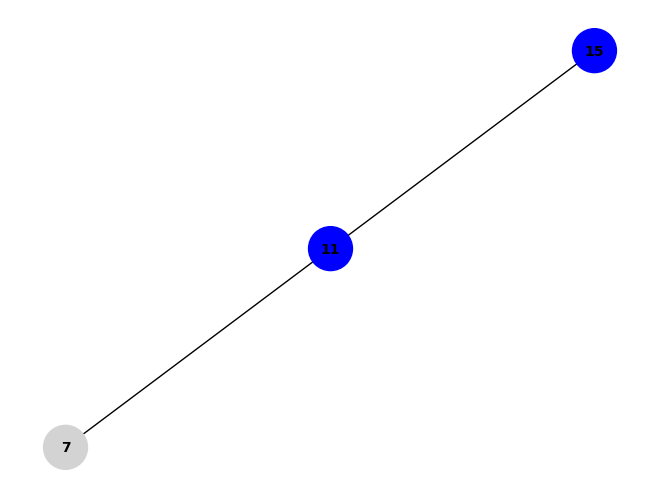

   Created sparse assignment with shape: (32, 32)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 15, 7)
Dummy node position: (x=12.3125, y=1.1111111111111112)


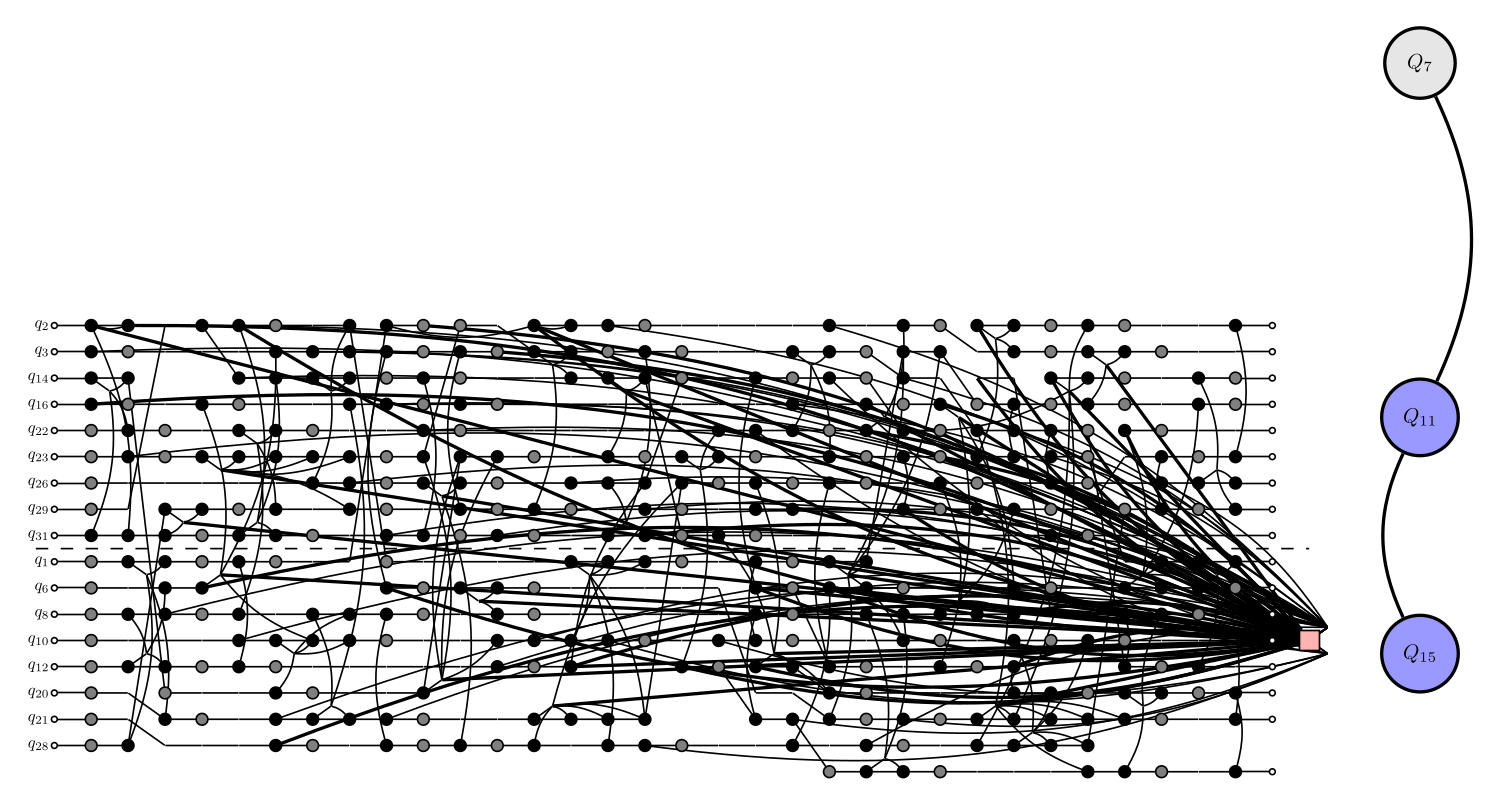

Partition counts for subgraph: [{11: 9, 15: 8}, {11: 9, 15: 8}, {11: 8, 15: 8}, {11: 8, 15: 8}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 6}, {11: 9, 15: 6}, {11: 9, 15: 6}, {11: 9, 15: 6}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 8, 15: 9}, {11: 8, 15: 9}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 7}, {11: 9, 15: 7}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 8}, {11: 9, 15: 8}]


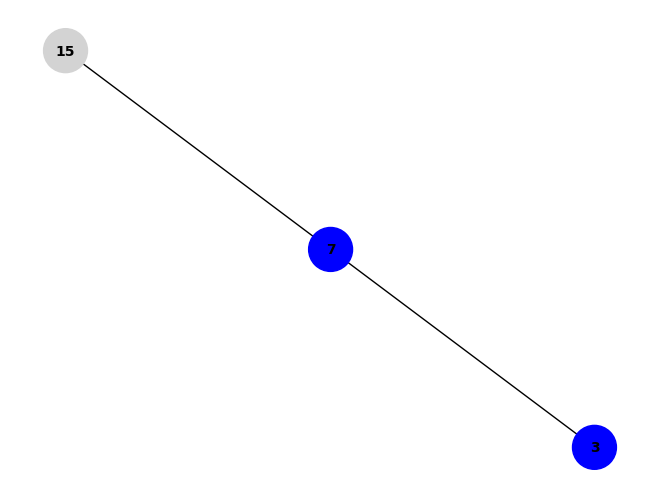

   Created sparse assignment with shape: (32, 32)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.1111111111111112)


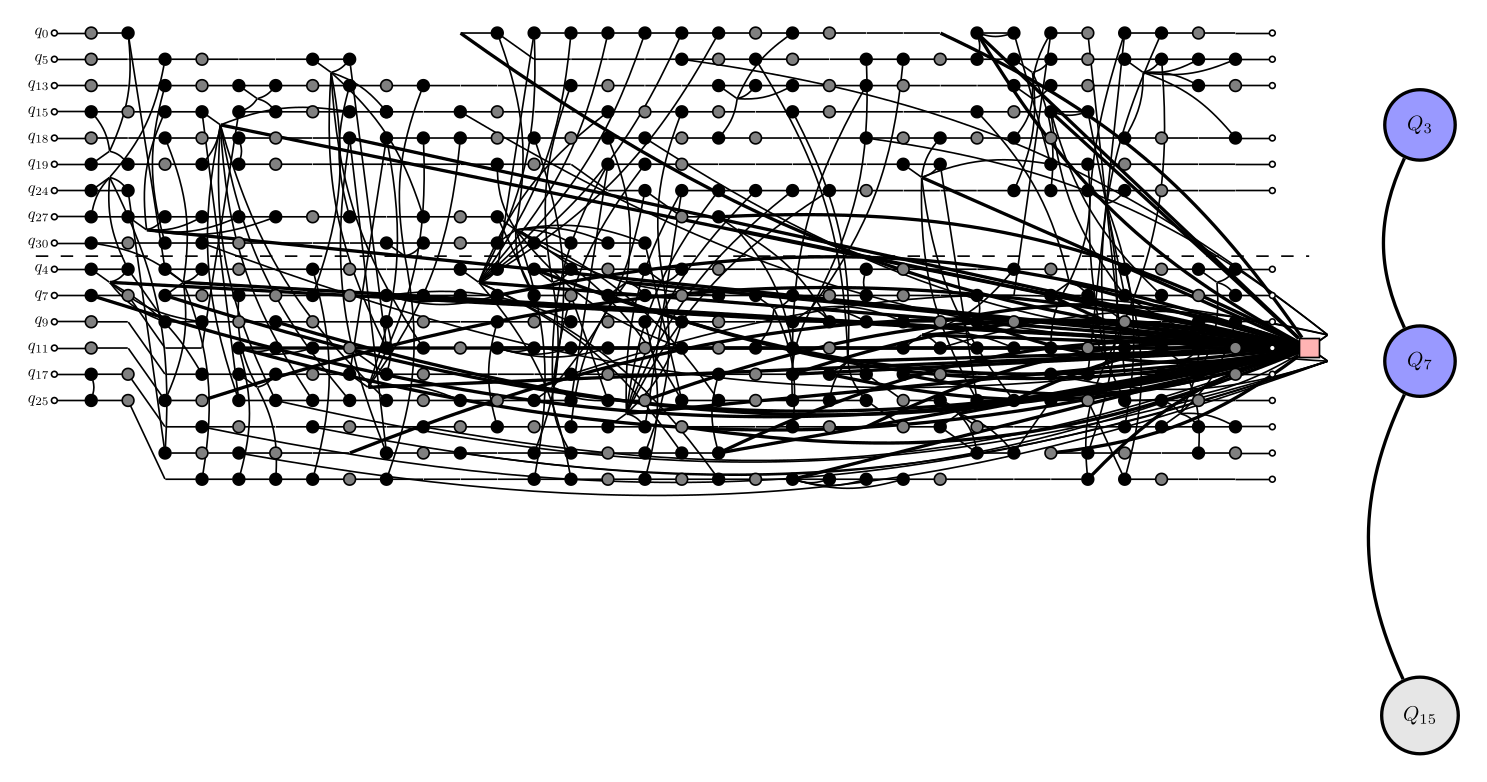

Partition counts for subgraph: [{3: 9, 7: 6}, {3: 9, 7: 6}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 6, 7: 9}, {3: 6, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 8, 7: 9}, {3: 8, 7: 9}, {3: 8, 7: 9}, {3: 8, 7: 9}, {3: 7, 7: 8}, {3: 7, 7: 8}, {3: 7, 7: 8}, {3: 7, 7: 8}, {3: 7, 7: 8}, {3: 7, 7: 8}, {3: 6, 7: 9}, {3: 6, 7: 9}, {3: 7, 7: 9}, {3: 7, 7: 9}, {3: 6, 7: 9}, {3: 6, 7: 9}, {3: 6, 7: 9}, {3: 6, 7: 9}]
   ✅ Subgraph 2 TikZ visualization complete!
\n✅ Subgraph visualization complete!
   Each visualization shows the circuit from one sub-network's perspective
   Real nodes belong to the sub-network, dummy nodes represent external qubits
   This enables independent optimization while preserving global dependencies


In [12]:
# Visualize the actual subgraphs using TikZ
print("🎨 Visualizing actual subgraphs with TikZ...")



coarsener = HypergraphCoarsener()

def set_initial_partitions_sparse(assignment, active_nodes, qpu_sizes, subgraph):
    sparse_assignment = assignment.copy()
    depth = len(assignment)

    spaces = [] 
    for i in range(depth):
        spaces_layer = []
        for qpu in qpu_sizes:
            spaces_layer_qpu = [qpu for q in range(qpu_sizes[qpu])]
            # print(f"Layer {i}, QPU {qpu}: {len(spaces_layer_qpu)} spaces")
            spaces_layer += spaces_layer_qpu
        # print(f"Layer {i} spaces: {spaces_layer}")
        spaces.append(spaces_layer)

    for i, layer in enumerate(sparse_assignment):
        for idx, qpu in enumerate(layer):
            if qpu in active_nodes:
                # print(f"Expanding QPU {qpu} in layer {i}")
                index = spaces[i].pop(0)
                # print(f"Assigning index {index} to QPU {qpu} in layer {i}")
                sparse_assignment[i][idx] = index
    
    return sparse_assignment

# Iterate through dictionary of subgraphs
sparse_assignments = []
for source_node, subgraph in subgraphs.items():

    sub_network = network_level_list[1][source_node]
    active_nodes = sub_network.active_nodes
    qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}
    node_colors = ['blue' if node in active_nodes else 'lightgray' for node in sub_network.qpu_graph.nodes]
    nx.draw(sub_network.qpu_graph, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold')
    plt.show()

    node_map = {node: idx for idx, node in enumerate(active_nodes)}

    dummy_nodes = set()
    for node in subgraph.nodes:
        if isinstance(node, tuple) and len(node) >= 3 and node[0] == 'dummy':
            dummy_nodes.add(node)
            qpu = node[2]
            node_map[qpu] = len(node_map)  # Assign dummy nodes to the end of the map
    
    # Create sparse assignment for this subgraph
    sparse_assignment = set_initial_partitions_sparse(
        assignment=optimized_assignment_coarse,
        active_nodes=active_nodes,
        qpu_sizes=qpu_sizes,
        subgraph=subgraph
    )

    # Check validity of the sparse assignment
    if not check_assignment_validity_internal(sparse_assignment, qpu_sizes, active_nodes):
        print("❌ Sparse assignment is invalid!")
        raise ValueError("Sparse assignment does not respect QPU capacities or active nodes.")
    
    print(f"   Created sparse assignment with shape: {np.array(sparse_assignment).shape}")
    
    # Use draw_subgraph_tikz for proper visualization
    # fig = draw_subgraph_tikz(
    #     subgraph, 
    #     sparse_assignment, 
    #     qpu_sizes, 
    #     node_map=node_map,
    #     fill_background=True, 
    #     show_labels=True
    # )
    # display(fig)

    partitioner = FiducciaMattheyses(
    circuit=circuit,
    initial_assignment=sparse_assignment,
    hypergraph=subgraph,
    qpu_info=qpu_sizes,
    num_partitions=len(active_nodes),
    active_nodes=active_nodes,
    limit=num_qubits,
    max_gain=4*hypergraph.depth,
    passes=10,
    stochastic=True,
    network=sub_network,
    node_map=node_map,
    sparse=True
    )
    results = partitioner.partition(hypergraph_coarsener=HypergraphCoarsener().coarsen_recursive_subgraph_batch, 
                                    sparse=True, level_limit=100, 
                                    passes_per_level=10)
    
    sparse_assignment = results['best_assignment']
    final_cost = results['best_cost']

    fig= draw_subgraph_tikz(subgraph,
    sparse_assignment,
    qpu_sizes,
    network=sub_network,
    node_map=node_map,
    show_labels=False,
    tikz_raw=False)
    display(fig)
    
    # Check validity of the final sparse assignment
    if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
        print("❌ Final sparse assignment is invalid!")
        raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")

    sparse_assignments.append(sparse_assignment)


    
print(f"   ✅ Subgraph {i} TikZ visualization complete!")

print("\\n✅ Subgraph visualization complete!")
print("   Each visualization shows the circuit from one sub-network's perspective")
print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")
print("   This enables independent optimization while preserving global dependencies")

In [ ]:
from disqco.parti.FM.net_coarsened_partitioning import stitch_solution_sparse
from disqco.parti.FM.FM_methods import calculate_full_cost_hetero

parent_assignment = stitch_solution_sparse(subgraphs, sparse_assignments, num_qubits, depth=hypergraph.depth)

final_cost = calculate_full_cost_hetero(hypergraph, parent_assignment, len(initial_network.qpu_sizes), {}, initial_network)

print(f"Final cost of the stitched solution: {final_cost}")

network_level_1 = net_coarsener.network_coarse_list[-2]

print("Network level 1 QPU sizes:", network_level_1.qpu_sizes)

if check_assignment_validity(parent_assignment, network_level_1.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("❌ Final assignment is NOT valid! Check capacity constraints and partitioning.")

# draw_graph_tikz(
#     hypergraph,
#     final_assignment,
#     initial_network.qpu_sizes,
#     fill_background=True,
#     show_labels=True
# )

NameError: name 'stitch_solution_sparse' is not defined

## Step 5.6: Create Second Level Subgraphs

Now we create subgraphs for the second level of network coarsening. Each optimized subgraph from the first level is further divided based on the second level of network cutting.

In [99]:
# Create second level subgraphs
print("🔧 Creating second level subgraphs...")
if len(network_level_list) > 2:
    all_new_subgraphs = {}
    print(subgraphs)
    counter = 0
    for i, (source_node, subgraph) in enumerate(subgraphs.items()):
        print(f"\n📂 Processing subgraph {i} (source: {source_node}) for second level...")
        print(f'Counter: {counter}')
        counter += 1
        
        # Get the optimized assignment for this subgraph
        optimized_assignment = sparse_assignments[i]
        # Find existing dummy nodes
        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) > 0 and node[0] == 'dummy':
                dummy_nodes.add(node)
        
        current_network = network_level_list[1][source_node]
        
        # Create new subgraphs for second level
        new_subgraphs = sub_graph_manager.build_partition_subgraphs(
            graph=subgraph,
            assignment=optimized_assignment,
            current_network=current_network,
            new_networks=network_level_list[2],
            old_dummy_nodes=dummy_nodes
        )

        all_new_subgraphs.update(new_subgraphs)

    print(f"✅ Created {len(all_new_subgraphs)} second-level subgraphs")

🔧 Creating second level subgraphs...
{15: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x121fd26d0>, 7: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x121fd28e0>}

📂 Processing subgraph 0 (source: 15) for second level...
Counter: 0

📂 Processing subgraph 1 (source: 7) for second level...
Counter: 1
✅ Created 4 second-level subgraphs


🔧 Partitioning second level subgraphs...
{11: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116c45020>, 15: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x12259a0a0>, 3: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x122599e90>, 7: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x122599f40>}


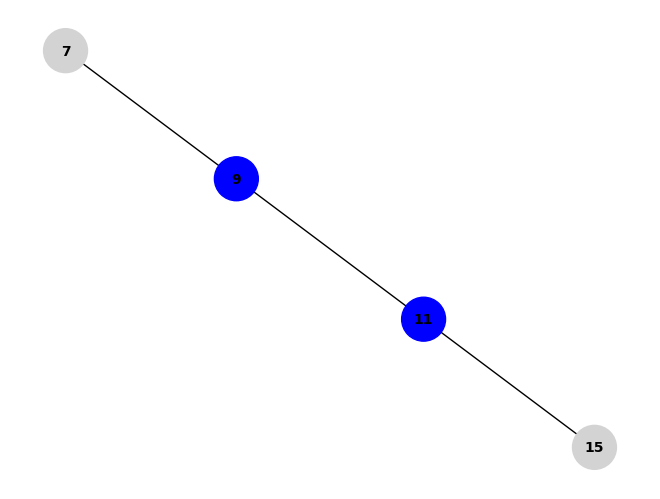

   Dummy nodes: {('dummy', 11, 7), ('dummy', 11, 15)}
Partition counts for subgraph: [{9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 3}, {9: 5, 11: 3}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 3}, {9: 5, 11: 3}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}]
Processing dummy node: ('dummy', 11, 7)
Dummy node position: (x=12.3125, y=1.5789473684210527)
Processing dummy node: ('dummy', 11, 15)
Dummy node position: (x=12.3125, y=1.894736842105263)
Processing dummy node: ('dummy', 11, 15)
Dummy node position: (x=12.3125, y=1.894736842105263)
Processing dummy node: ('dummy', 11, 7)
Dummy node position: (x=12.3125, y=1.5789473684210527)
Processing dummy node: ('dummy', 11, 7)
Dummy node pos

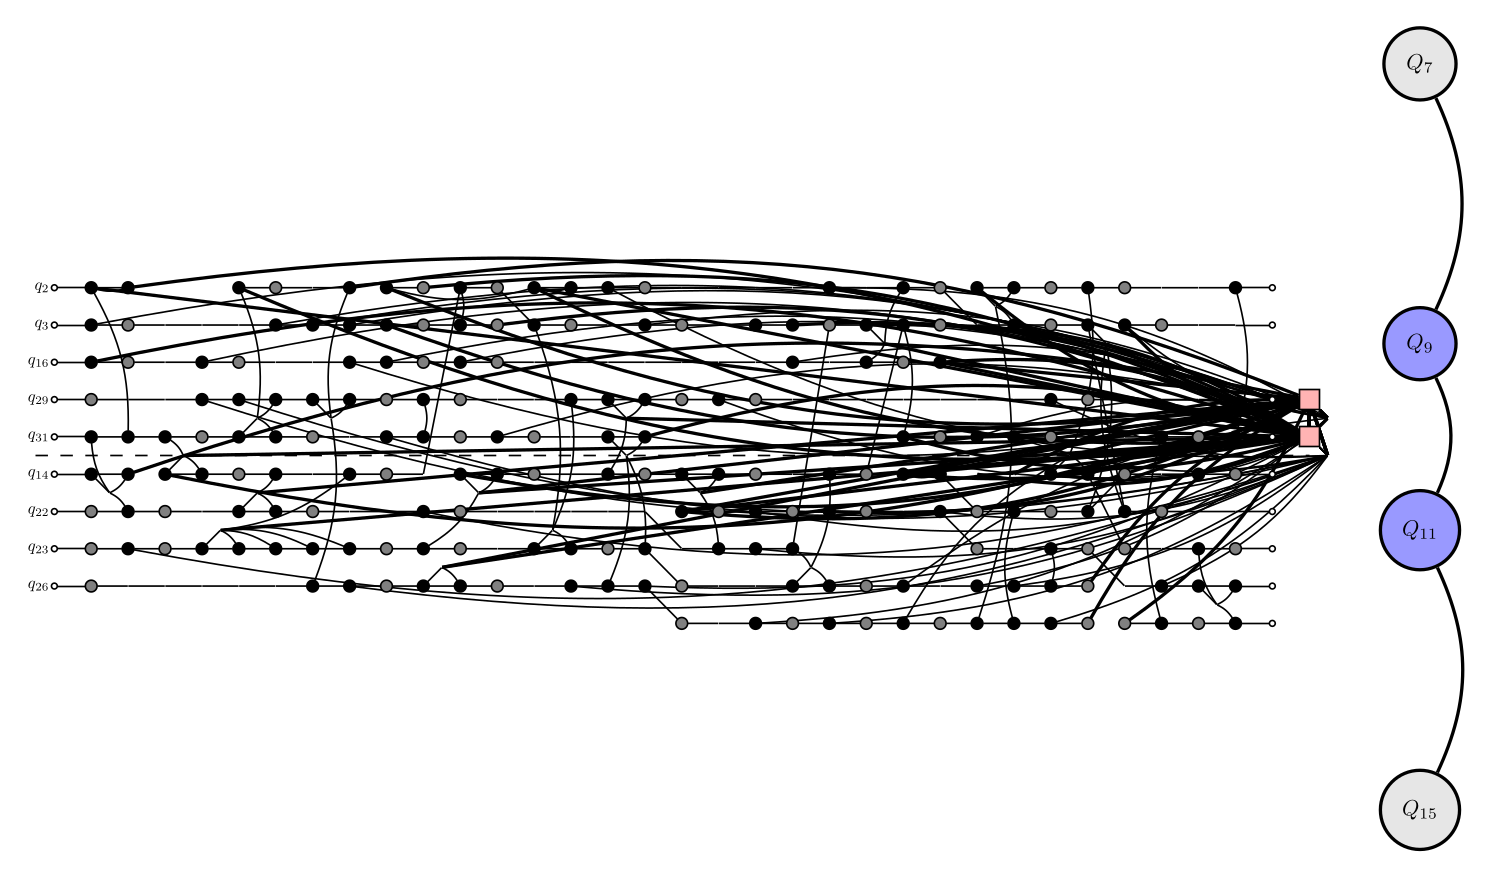

Partition counts for subgraph: [{9: 5, 11: 4}, {9: 5, 11: 4}, {9: 4, 11: 4}, {9: 4, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 4}, {9: 4, 11: 4}, {9: 5, 11: 4}, {9: 5, 11: 4}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}, {9: 4, 11: 5}]


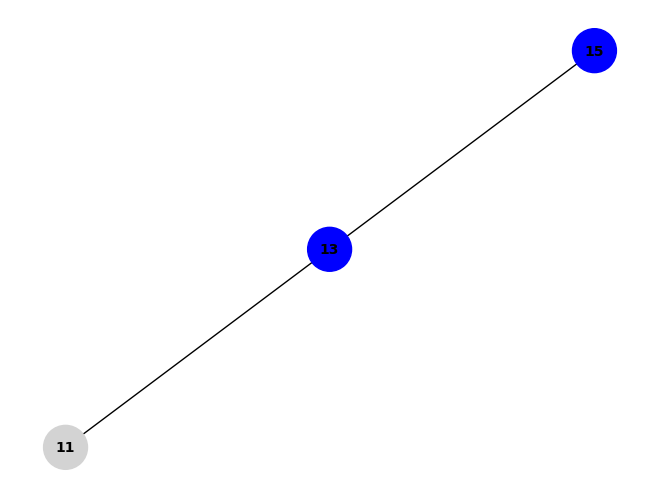

   Dummy nodes: {('dummy', 15, 11)}
Partition counts for subgraph: [{13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 1}, {13: 5, 15: 1}, {13: 5, 15: 1}, {13: 5, 15: 1}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 4}, {13: 5, 15: 4}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}]
Processing dummy node: ('dummy', 15, 11)
Dummy node position: (x=12.3125, y=1.6666666666666665)
Processing dummy node: ('dummy', 15, 11)
Dummy node position: (x=12.3125, y=1.6666666666666665)
Processing dummy node: ('dummy', 15, 11)
Dummy node position: (x=12.3125, y=1.6666666666666665)
Processing dummy node: ('dummy', 15, 11)
Dummy node position: (x=12.3125, y=1.6666666666666665)
Processing dummy node: ('dummy', 15,

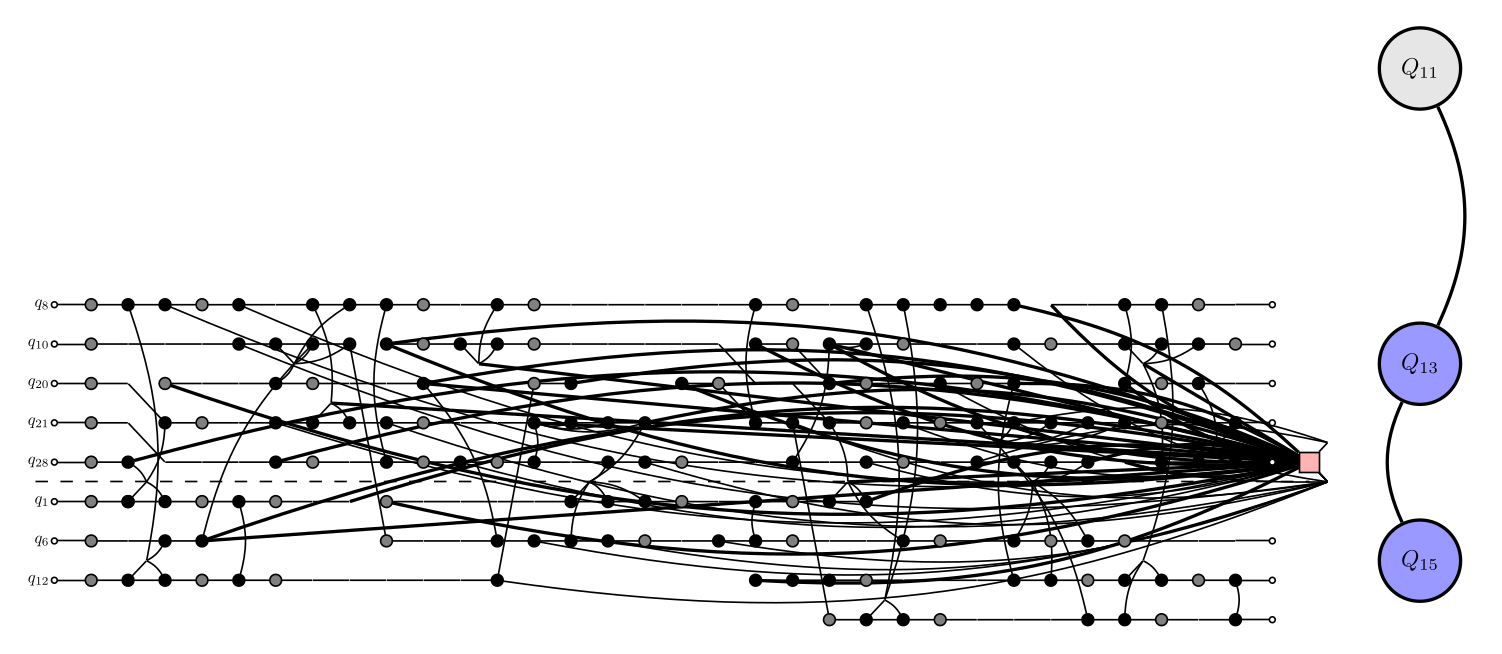

Partition counts for subgraph: [{13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 4, 15: 3}, {13: 4, 15: 3}, {13: 5, 15: 2}, {13: 5, 15: 2}, {13: 4, 15: 2}, {13: 4, 15: 2}, {13: 4, 15: 2}, {13: 4, 15: 2}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 4}, {13: 5, 15: 4}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 4, 15: 3}, {13: 4, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}, {13: 5, 15: 3}]


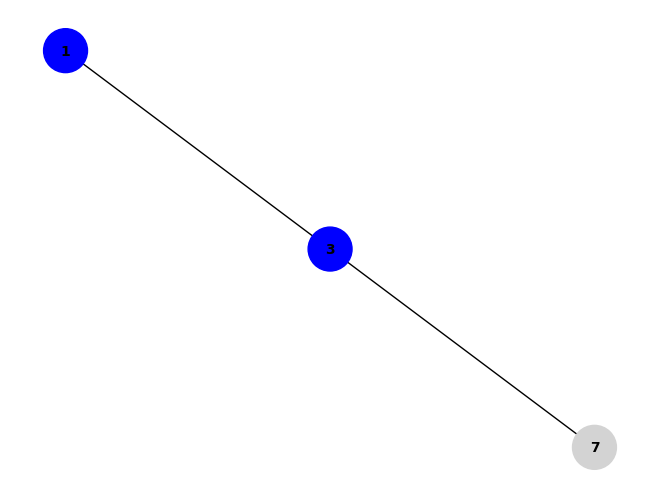

   Dummy nodes: {('dummy', 3, 7)}
Partition counts for subgraph: [{1: 5, 3: 4}, {1: 5, 3: 4}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 1}, {1: 5, 3: 1}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 3}, {1: 5, 3: 3}, {1: 5, 3: 3}, {1: 5, 3: 3}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 1}, {1: 5, 3: 1}, {1: 5, 3: 2}, {1: 5, 3: 2}, {1: 5, 3: 1}, {1: 5, 3: 1}, {1: 5, 3: 1}, {1: 5, 3: 1}]
Processing dummy node: ('dummy', 3, 7)
Dummy node position: (x=12.3125, y=1.7647058823529411)
Processing dummy node: ('dummy', 3, 7)
Dummy node position: (x=12.3125, y=1.7647058823529411)
Processing dummy node: ('dummy', 3, 7)
Dummy node position: (x=12.3125, y=1.7647058823529411)
Processing dummy node: ('dummy', 3, 7)
Dummy node position: (x=12.3125, y=1.7647058823529411)
Processing dummy node: ('dummy', 3, 7)
Dummy node position: (x=12.3125, y=1.7647058823529411)
Processing dummy

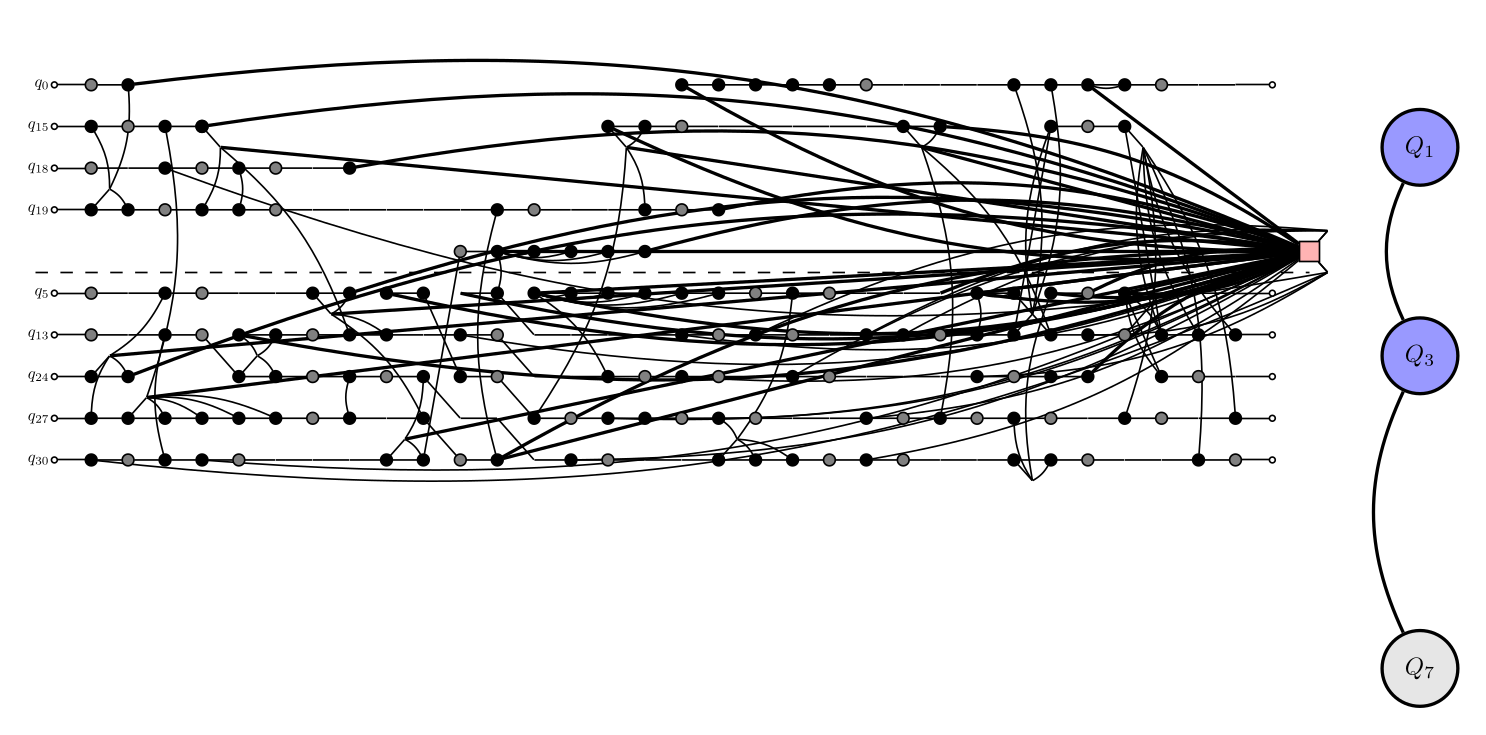

Partition counts for subgraph: [{1: 4, 3: 5}, {1: 4, 3: 5}, {1: 3, 3: 4}, {1: 3, 3: 4}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 1, 3: 5}, {1: 1, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 3, 3: 5}, {1: 3, 3: 5}, {1: 3, 3: 5}, {1: 3, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 1, 3: 5}, {1: 1, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 5}, {1: 2, 3: 4}, {1: 1, 3: 5}, {1: 1, 3: 5}, {1: 1, 3: 5}]


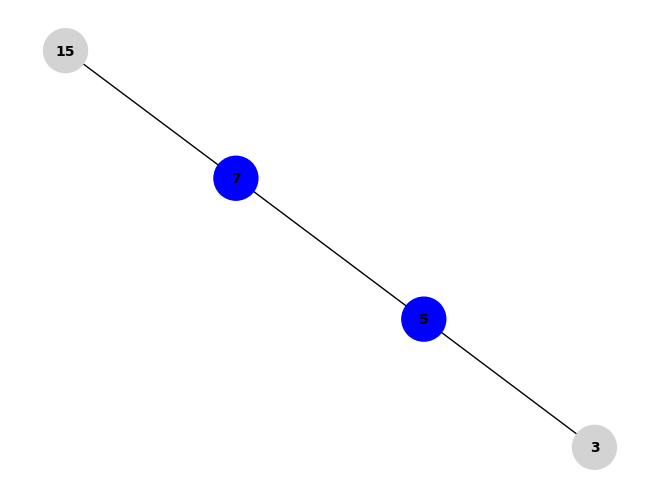

   Dummy nodes: {('dummy', 7, 3), ('dummy', 7, 15)}
Partition counts for subgraph: [{5: 5, 7: 1}, {5: 5, 7: 1}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 3}, {5: 5, 7: 3}, {5: 5, 7: 3}, {5: 5, 7: 3}, {5: 5, 7: 3}, {5: 5, 7: 3}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}]
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.3043478260869565)
Processing dummy node: ('dummy', 7, 3)
Dummy node position: (x=12.3125, y=1.5652173913043477)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.3043478260869565)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.3043478260869565)
Processing dummy node: ('dummy', 7, 15)
Dummy node position: (x=12.3125, y=1.304347826086

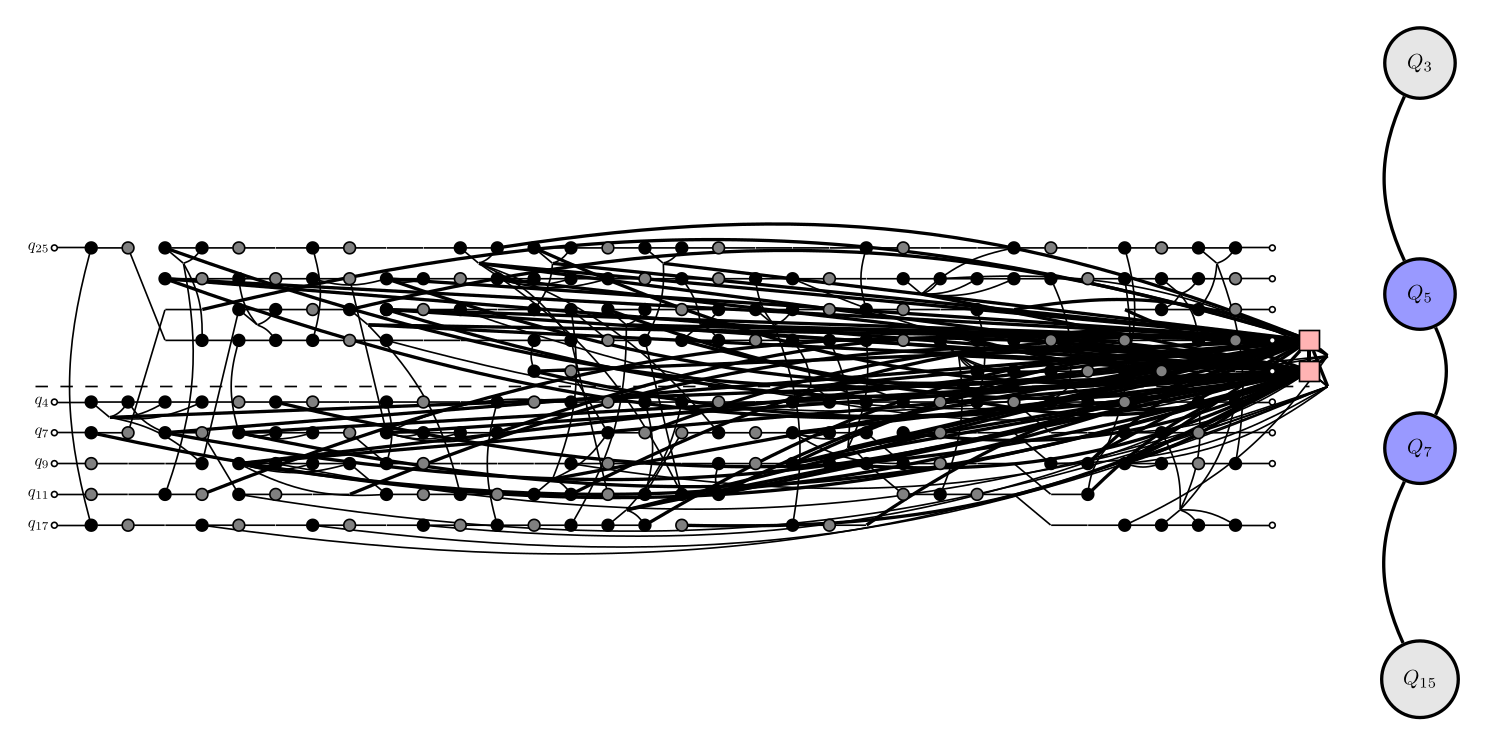

Partition counts for subgraph: [{5: 1, 7: 5}, {5: 1, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 4, 7: 4}, {5: 4, 7: 4}, {5: 4, 7: 4}, {5: 4, 7: 4}, {5: 4, 7: 4}, {5: 4, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 4, 7: 5}, {5: 4, 7: 5}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}, {5: 5, 7: 4}]

✅ Second level subgraph optimization complete!
   Each visualization shows the optimized circuit from each second-level sub-network's perspective
   Real nodes belong to the sub-network, dummy nodes represent external qubits


In [100]:
# Partition second level subgraphs using the same approach as first level
print("🔧 Partitioning second level subgraphs...")

if len(network_level_list) > 2:

    coarsener = HypergraphCoarsener()

    # Iterate through dictionary of second level subgraphs
    second_level_sparse_assignments = []
    subgraphs = all_new_subgraphs

    print(subgraphs)

    for source_node, subgraph in subgraphs.items():

        sub_network = network_level_list[2][source_node]
        active_nodes = sub_network.active_nodes
        qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}

        node_colors = ['blue' if node in active_nodes else 'lightgray' for node in sub_network.qpu_graph.nodes]
        nx.draw(sub_network.qpu_graph, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold')
        plt.show()

        node_map = {node: idx for idx, node in enumerate(active_nodes)}

        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) >= 3 and node[0] == 'dummy':
                dummy_nodes.add(node)
                qpu = node[2]
                node_map[qpu] = len(node_map)  # Assign dummy nodes to the end of the map
        
        print(f"   Dummy nodes: {dummy_nodes}")
        
        # Create sparse assignment for this subgraph
        # Find the parent assignment from first level subgraphs
        # For now, use the optimized assignment from coarsest network as parent
        parent_assignment = parent_assignment
        
        sparse_assignment = set_initial_partitions_sparse(
            assignment=parent_assignment,
            active_nodes=active_nodes,
            qpu_sizes=qpu_sizes,
            subgraph=subgraph
        )

        # Check validity of the sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Sparse assignment is invalid!")
            raise ValueError("Sparse assignment does not respect QPU capacities or active nodes.")

        init_cost = calculate_full_cost_hetero(
            hypergraph=subgraph,
            assignment=sparse_assignment,
            num_partitions=len(active_nodes),
            costs={},
            network=sub_network,
            node_map=node_map,
            dummy_nodes=dummy_nodes
        )
        
        # Use coarsen_recursive_subgraph_batch and multilevel optimization
        partitioner = FiducciaMattheyses(
            circuit=None,
            initial_assignment=sparse_assignment,
            hypergraph=subgraph,
            qpu_info=qpu_sizes,
            num_partitions=len(active_nodes),
            active_nodes=active_nodes,
            limit=num_qubits,
            max_gain=4*hypergraph.depth,
            passes=10,
            stochastic=True,
            network=sub_network,
            node_map=node_map,
            sparse=True
        )
        results = partitioner.partition(hypergraph_coarsener=HypergraphCoarsener().coarsen_recursive_subgraph_batch, 
                                        sparse=True, level_limit=100, 
                                        passes_per_level=10)
        sparse_assignment = results['best_assignment']
        final_cost = results['best_cost']



        fig = draw_subgraph_tikz(
            subgraph,
            sparse_assignment,
            qpu_sizes,
            network=sub_network,
            node_map=node_map,
            fill_background=True,
            show_labels=False
        )
        display(fig)
        # Check validity of the final sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Final sparse assignment is invalid!")
            raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")
        
        second_level_sparse_assignments.append(sparse_assignment)

    print("\n✅ Second level subgraph optimization complete!")
    print("   Each visualization shows the optimized circuit from each second-level sub-network's perspective")
    print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")

In [101]:
from disqco.parti.FM.net_coarsened_FM import stitch_solution_sparse
from disqco.parti.FM.FM_methods import calculate_full_cost_hetero

print(f'Number of second-level sparse assignments: {len(second_level_sparse_assignments)}')
print(f'Number of subgraphs: {len(subgraphs)}')
parent_assignment = stitch_solution_sparse(subgraphs, second_level_sparse_assignments, num_qubits, depth=hypergraph.depth)

final_cost = calculate_full_cost_hetero(hypergraph, parent_assignment, len(initial_network.qpu_sizes), {}, initial_network)

print(f"Final cost of the stitched solution: {final_cost}")

network_level_2 = net_coarsener.network_coarse_list[-3]

if check_assignment_validity(parent_assignment, network_level_2.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("❌ Final assignment is NOT valid! Check capacity constraints and partitioning.")

# draw_graph_tikz(
#     hypergraph,
#     final_assignment,
#     initial_network.qpu_sizes,
#     fill_background=True,
#     show_labels=True
# )

Number of second-level sparse assignments: 4
Number of subgraphs: 4
Final cost of the stitched solution: 500
Partition counts for subgraph: [{1: 4, 3: 5, 5: 1, 7: 5, 9: 5, 11: 4, 13: 5, 15: 3}, {1: 4, 3: 5, 5: 1, 7: 5, 9: 5, 11: 4, 13: 5, 15: 3}, {1: 3, 3: 4, 5: 4, 7: 5, 9: 4, 11: 4, 13: 5, 15: 3}, {1: 3, 3: 4, 5: 4, 7: 5, 9: 4, 11: 4, 13: 5, 15: 3}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 1, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 3}, {1: 1, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 5, 15: 3}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 4, 15: 3}, {1: 2, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 4, 15: 3}, {1: 2, 3: 5, 5: 5, 7: 4, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 2, 3: 5, 5: 5, 7: 4, 9: 5, 11: 4, 13: 5, 15: 2}, {1: 3, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 4, 15: 2}, {1: 3, 3: 5, 5: 4, 7: 5, 9: 5, 11: 4, 13: 4, 15: 2}, {1: 3, 3: 5

In [ ]:
# Create third level subgraphs
print("🔧 Creating third level subgraphs...")

if len(network_level_list) > 3:

    all_new_subgraphs = {}
    counter = 0
    for i, (source_node, subgraph) in enumerate(subgraphs.items()):
        print(f"\n📂 Processing subgraph {i} (source: {source_node}) for third level...")
        print(f'Counter: {counter}')
        counter += 1
        
        # Get the optimized assignment for this subgraph
        optimized_assignment = second_level_sparse_assignments[i]
        # Find existing dummy nodes
        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) > 0 and node[0] == 'dummy':
                dummy_nodes.add(node)
        
        current_network = network_level_list[2][source_node]
        
        # Create new subgraphs for second level
        new_subgraphs = sub_graph_manager.build_partition_subgraphs(
            graph=subgraph,
            assignment=optimized_assignment,
            current_network=current_network,
            new_networks=network_level_list[3],
            old_dummy_nodes=dummy_nodes
        )

        all_new_subgraphs.update(new_subgraphs)

    print(f"✅ Created {len(all_new_subgraphs)} second-level subgraphs")




🔧 Creating third level subgraphs...

📂 Processing subgraph 0 (source: 11) for third level...
Counter: 0

📂 Processing subgraph 1 (source: 15) for third level...
Counter: 1

📂 Processing subgraph 2 (source: 3) for third level...
Counter: 2

📂 Processing subgraph 3 (source: 7) for third level...
Counter: 3
✅ Created 8 second-level subgraphs


In [103]:
# Third level partitioning

if len(network_level_list) > 3:

    print("🔧 Partitioning third level subgraphs...")

    coarsener = HypergraphCoarsener()

    # Iterate through dictionary of third level subgraphs
    third_level_sparse_assignments = []
    subgraphs = all_new_subgraphs

    print(subgraphs)

    for source_node, subgraph in subgraphs.items():

        sub_network = network_level_list[3][source_node]
        active_nodes = sub_network.active_nodes
        qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}
        print("source_node:", source_node)
        print(f'active_nodes: {active_nodes}')
        print(f'qpu_sizes: {qpu_sizes}')

        node_map = {node: idx for idx, node in enumerate(active_nodes)}

        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) >= 3 and node[0] == 'dummy':
                dummy_nodes.add(node)
                qpu = node[2]
                node_map[qpu] = len(node_map)  # Assign dummy nodes to the end of the map
        
        print(f"   Dummy nodes: {dummy_nodes}")
        
        
        sparse_assignment = set_initial_partitions_sparse(
            assignment=parent_assignment,
            active_nodes=active_nodes,
            qpu_sizes=qpu_sizes,
            subgraph=subgraph
        )

        # Check validity of the sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Sparse assignment is invalid!")
            raise ValueError("Sparse assignment does not respect QPU capacities or active nodes.")
        print(f"Assignment is valid for subgraph {source_node}")

        init_cost = calculate_full_cost_hetero(
            hypergraph=subgraph,
            assignment=sparse_assignment,
            num_partitions=len(active_nodes),
            costs={},
            network=sub_network,
            node_map=node_map,
            dummy_nodes=dummy_nodes
        )

        # fig = draw_subgraph_tikz(
        #     subgraph,
        #     sparse_assignment,
        #     qpu_sizes,
        #     node_map=node_map,
        #     fill_background=True,
        #     show_labels=True
        # )
        # display(fig)

        print(f"   Initial cost for subgraph: {init_cost}")

        print(f"sparse_assignment: {sparse_assignment}")
        
        print(f"   Created sparse assignment with shape: {np.array(sparse_assignment).shape}")
        
        # Use coarsen_recursive_subgraph_batch and multilevel optimization
        graph_list, mapping_list = coarsener.coarsen_recursive_subgraph_batch(subgraph)

        for level, (graph, mapping) in enumerate(zip(graph_list[::-1], mapping_list[::-1])):
            # Partition subgraphs in sequence
            print(f'dummy_nodes: {dummy_nodes}')

            final_cost, final_assignment, _ = run_FM_sparse(
                                                hypergraph=graph,
                                                initial_assignment=sparse_assignment,
                                                qpu_info=qpu_sizes,
                                                num_partitions=len(active_nodes),
                                                active_nodes=active_nodes,
                                                limit=num_qubits,
                                                max_gain=4*hypergraph.depth,
                                                passes=10,  # Quick optimization
                                                stochastic=True,
                                                log=True,
                                                network=sub_network,
                                                node_map=node_map,
                                                dummy_nodes=dummy_nodes
                                            )
            

            
            print(f"Assignment is valid for subgraph after optimisation {source_node}")
            
            print(f'final_assignment: {final_assignment}')

            sparse_assignment = refine_assignment_sparse(
                level=level,
                num_levels=len(graph_list),
                assignment=final_assignment,
                mapping_list=mapping_list[::-1],
                subgraph=subgraph,
                next_graph=graph_list[::-1][level+1] if level < len(graph_list) - 1 else subgraph,
                qpu_sizes=qpu_sizes
            )
            print("refined sparse assignment:", sparse_assignment)

        # Check validity of the final sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Final sparse assignment is invalid!")
            raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")
        
        third_level_sparse_assignments.append(sparse_assignment)

    print("\n✅ Third level subgraph optimization complete!")
    print("   Each visualization shows the optimized circuit from each third-level sub-network's perspective")
    print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")

🔧 Partitioning third level subgraphs...
{9: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116a34940>, 11: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116a34730>, 13: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116a349f0>, 15: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116a35020>, 1: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x12259aa40>, 3: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x12259a830>, 5: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x12259a570>, 7: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x116a35230>}
source_node: 9
active_nodes: {8, 9}
qpu_sizes: {8: 3, 9: 3}
   Dummy nodes: {('dummy', 9, 11), ('dummy', 9, 7)}
Partition counts for subgraph: [{8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 1}, {8: 3, 9: 1}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 2}, {8: 3, 9: 

## Step 5.8: Stitch Solutions Together

The final step is to combine all the optimized subgraph solutions into a single complete assignment using the sparse solution stitching method.

In [104]:
# Stitch second-level solutions

if len(network_level_list) > 3:

    final_assignment_unwrapped = stitch_solution_sparse(
        subgraphs, third_level_sparse_assignments, num_qubits, depth=hypergraph.depth
    )

    network_level_3 = net_coarsener.network_coarse_list[-4]

    print("Network level 3 QPU sizes:", network_level_3.qpu_sizes)


    # Check final assignment validity
    if check_assignment_validity(final_assignment_unwrapped, network_level_3.qpu_sizes, hypergraph):
        print("✅ Final scond-level assignment is valid!")
    else:
        print("❌ Final -level assignment is NOT valid! Check capacity constraints and partitioning.")
        raise ValueError("Final assignment does not satisfy capacity constraints.")

    final_cost = calculate_full_cost_hetero(
        hypergraph, final_assignment_unwrapped, len(initial_network.qpu_sizes), {}, initial_network)

    print(f"Final cost of the stitched second-level solution: {final_cost}")

Network level 3 QPU sizes: {0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3}
Partition counts for subgraph: [{0: 1, 1: 3, 2: 2, 3: 3, 4: 0, 5: 1, 6: 3, 7: 2, 8: 3, 9: 2, 10: 2, 11: 2, 12: 3, 13: 2, 14: 3, 15: 0}, {0: 1, 1: 3, 2: 2, 3: 3, 4: 0, 5: 1, 6: 3, 7: 2, 8: 3, 9: 2, 10: 2, 11: 2, 12: 3, 13: 2, 14: 3, 15: 0}, {0: 0, 1: 3, 2: 2, 3: 2, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 2, 14: 3, 15: 0}, {0: 0, 1: 3, 2: 2, 3: 2, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3, 11: 1, 12: 3, 13: 2, 14: 3, 15: 0}, {0: 0, 1: 2, 2: 2, 3: 3, 4: 1, 5: 3, 6: 2, 7: 3, 8: 2, 9: 3, 10: 3, 11: 1, 12: 3, 13: 2, 14: 2, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 2, 4: 1, 5: 3, 6: 2, 7: 3, 8: 2, 9: 3, 10: 2, 11: 2, 12: 3, 13: 2, 14: 2, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3, 8: 2, 9: 3, 10: 3, 11: 1, 12: 3, 13: 2, 14: 2, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3, 8: 2, 9: 3, 10: 3, 11: 1, 12: 3, 13: 2, 14: 2, 15: 0}, {0: 0,

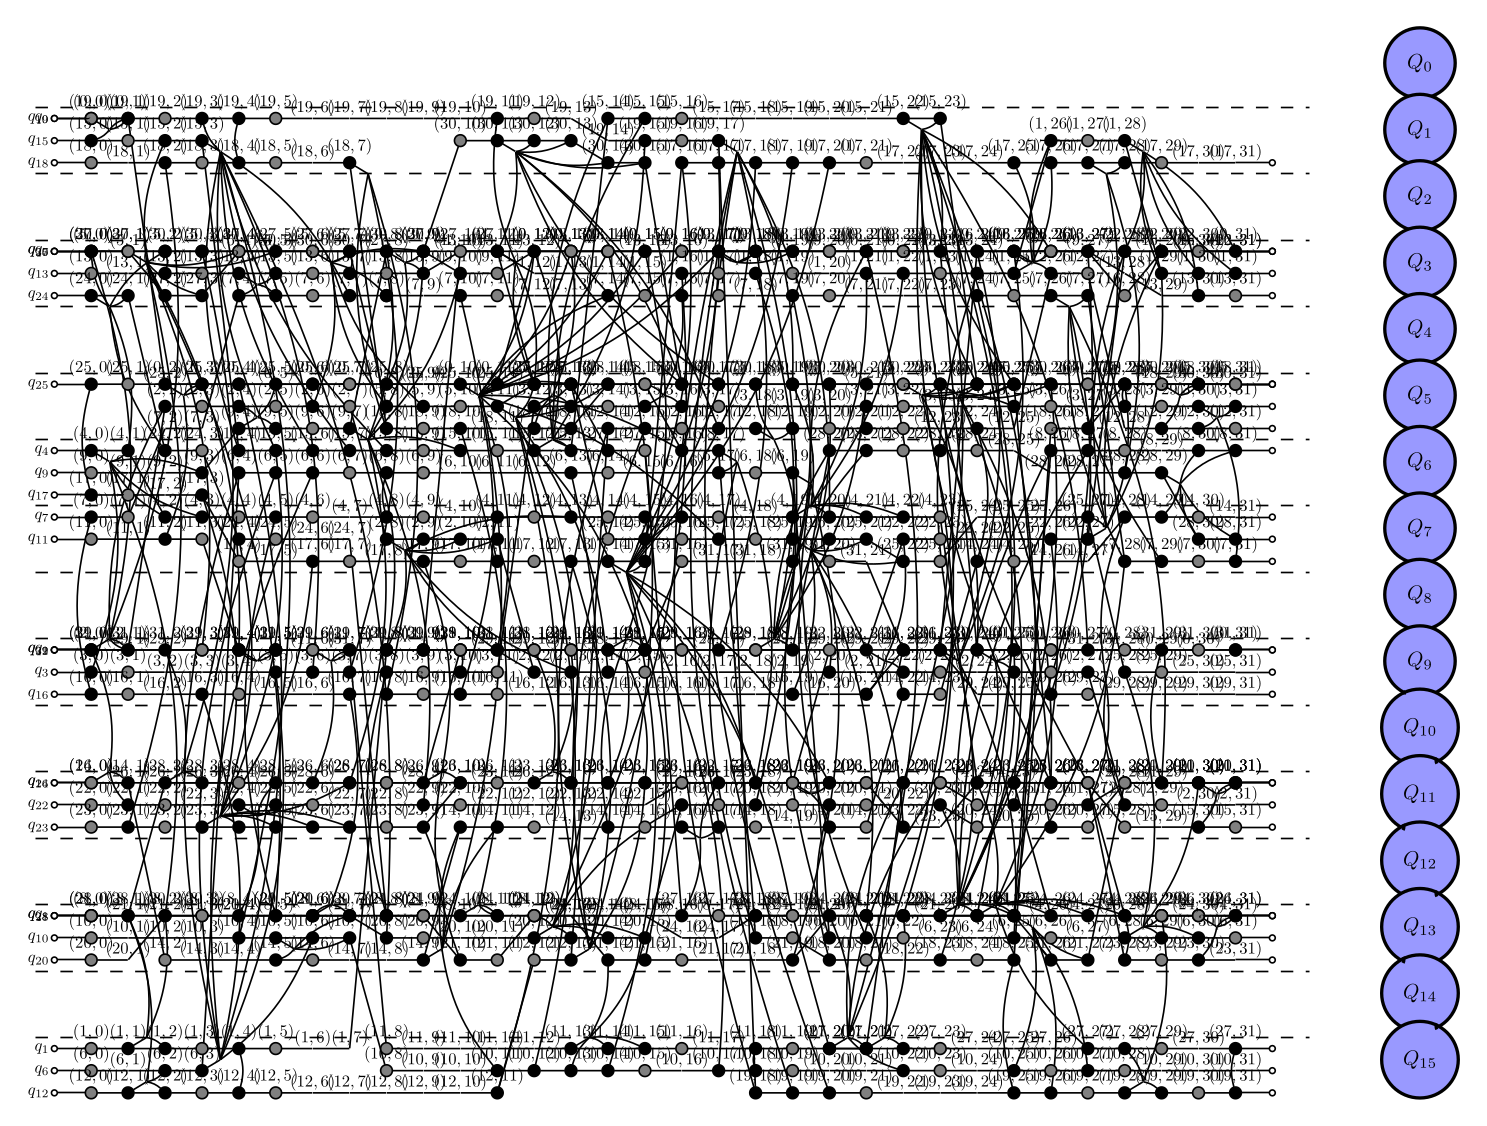

In [105]:
fig = draw_subgraph_tikz(
    hypergraph,
    final_assignment,
    initial_network.qpu_sizes,
    network=initial_network,
)
display(fig)

In [106]:
from disqco.parti.FM.net_coarsened_partitioning import run_full_net_coarsened_FM

# Example usage:
results = run_full_net_coarsened_FM(
    hypergraph=hypergraph,
    num_qubits=num_qubits,
    network=initial_network,
    coarsening_factor=4,
    passes_per_level=10,
    use_multiprocessing=True,
)
final_assignment = results['best_assignment']
print(f"Final cost: {results['best_cost']}")



# Check final assignment validity
if check_assignment_validity(final_assignment, initial_network.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("❌ Final assignment is NOT valid! Check capacity constraints and partitioning.")
    print(f"Previous solution validity: {check_assignment_validity(final_assignment_unwrapped, initial_network.qpu_sizes, hypergraph)}")
    raise ValueError("Final assignment does not satisfy capacity constraints.")

Final cost: 509
Partition counts for subgraph: [{0: 0, 1: 3, 2: 3, 3: 3, 4: 1, 5: 3, 6: 2, 7: 2, 8: 3, 9: 3, 10: 1, 11: 2, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 3, 3: 3, 4: 1, 5: 3, 6: 2, 7: 2, 8: 3, 9: 3, 10: 1, 11: 2, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 3, 3: 3, 4: 1, 5: 2, 6: 3, 7: 3, 8: 3, 9: 2, 10: 2, 11: 1, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 3, 3: 2, 4: 1, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3, 10: 2, 11: 1, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 3, 3: 3, 4: 0, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 0, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 3, 4: 0, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 0, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 3, 4: 0, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 0, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 2, 2: 3, 3: 3, 4: 0, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 0, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 3, 3: 3, 4: 0, 5: 3, 6: 3, 7: 3, 8: 2, 9: 3, 10: 3, 11: 0, 12: 3, 13: 3, 14: 0, 15: 0}, {0: 0, 1: 3, 2: 